# Practice Session 6: Non-Normally Distributed Data and Non-Parametric Tests

In [ ]:
# Install the outlier_utils package
# We will use it in today's practice session to perform the Grubbs' test for detecting outliers
!pip install outlier_utils


In [110]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import ttest_1samp, ttest_ind, ttest_rel, f, shapiro, levene, wilcoxon, mannwhitneyu
from outliers import smirnov_grubbs as grubbs

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Part 1: Understanding Non-Normal Data and Outliers

So far, all the hypothesis tests we have used assumed that the data were **normally distributed**.  
But what if that assumption does not hold?

There are many reasons why data might **not follow a normal distribution**.\
As we already saw in **Practice Session 2**, environmental data often follow **log-normal**, **exponential**, or other **skewed** distributions.\
In some cases, a **data transformation** (for example, log-transform) can make the data approximately normal.  

However, non-normality can also arise from the presence of **outliers**, which can introduce or increase skewness in the data.

**A quick reminder: what is skewness?**\
**Skewness** measures how asymmetric a distribution is relative to the mean:
- A **positive skew** (right-skewed) means a longer tail on the **right** side (e.g., most values are small, but a few are much larger).  
- A **negative skew** (left-skewed) means a longer tail on the **left** side (e.g., most values are large, but a few are much smaller).  

In **Homework 1**, you already calculated the **sample skewness** and **excess kurtosis** of your dataset.

**How much skewness or kurtosis is "acceptable"?**\
In practice, **small deviations from normality are usually not a problem** - most parametric tests, such as the *t*-test, are fairly robust to mild non-normality.  

Below are commonly used **rule-of-thumb thresholds** for interpreting **skewness**:
| Distribution shape | Skewness range | Interpretation |
|:---|:---:|:---|
| Approximately normal | −0.5 to +0.5 | Distribution is close to symmetric |
| Moderately skewed | −1 to −0.5 or +0.5 to +1 | Noticeable asymmetry |
| Highly skewed | ≤ −1 or ≥ +1 | Strong asymmetry, non-normal |

For **excess kurtosis**, values between **−0.5 and +0.5** are typically considered *close to normal* (that is, the distribution’s tails and peak resemble those of a normal curve.)
<div style="display: flex; align-items: center; justify-content: space-around;">
  <img src="https://raw.githubusercontent.com/RaHub4AI/MI7032/refs/heads/main/Pictures/skew.png" alt="Skewness illustration" width="48%">
  <img src="https://raw.githubusercontent.com/RaHub4AI/MI7032/refs/heads/main/Pictures/kurtosis.png" alt="Kurtosis illustration" width="48%">
</div>

**A note on outliers**\
On boxplots, potential outliers are displayed as **individual points**.  
They are identified when they fall more than **1.5 × IQR (interquartile range)** below the first quartile (Q1) or above the third quartile (Q3).\
This is a **visual guideline** (a quick way to spot unusual values) but it is **not a formal statistical test** for identifying outliers.


#### The Grubbs’ test for outliers
If we want to formally test whether a single observation is an outlier, we can use the **Grubbs’ test** (also called the **maximum normalized residual test**).\
The test detects **one outlier at a time** by comparing the largest deviation from the mean to the overall standard deviation: $G = \frac{\max |x_i - \bar{x}|}{s}$, where:
- $\bar{x}$ is the sample mean,  
- $s$ is the sample standard deviation, and  
- $x_i$ is an observation in the dataset.

The Grubbs’ test checks the following hypotheses:
- **Null hypothesis ($H_0$)**: There are **no outliers** in the data.  
- **Alternative hypothesis ($H_1$)**: There is **at least one outlier**.

If the computed test statistic $G$ exceeds the critical value (based on the *t*-distribution), we reject $H_0$ and conclude that the most extreme value is a statistical outlier.

> *Note:* Grubbs’ test assumes **normality** of the underlying data.


#### <font color="#fc7202">Task 1:</font>
You are given a 1D dataset (see the code cell below).  

1) **Visualize** the data (boxplot, histogram, Q-Q plot).  
2) **Describe** the data (count, mean, median, std, skewness, excess kurtosis).  
3) If the plots indicate **potential outliers**, apply the **Grubbs’ test** (testing one suspected outlier at a time).
   - If an outlier is detected, remove it, then repeat the descriptive analysis and plotting for the cleaned dataset.
4) Briefly **summarize** what changed after removing outliers.

*Hint:* Use the `grubbs()` function from the **`outliers.smirnov_grubbs`** module (already imported for you as `grubbs.test()`) to perform the **Grubbs’ test** for detecting statistical outliers.

In [25]:
dataset_outliers = pd.DataFrame({'measurement_id': np.arange(1, 21),
                                 'observed_value': [0.4, 1.7, 0.6, 74.9, 13.9, 0.8, 20.2, 143.2, 725.7, 0.2, 160.2, 14.7, 5.0, 2.9, 171.7, 20.4, 1.4, 17.1, 79.7, 27.6]})

In [166]:
dataset_outliers.describe()

,measurement_id,observed_value
count,20.00000,20.000000
mean,10.50000,74.115000
std,5.91608,163.307947
min,1.00000,0.200000
25%,5.75000,1.625000
50%,10.50000,15.900000
75%,15.25000,76.100000
max,20.00000,725.700000


In [14]:
# Calculating the skewness and excess kurtosis
print(f'Skewness of the original dataset: {dataset_outliers.observed_value.skew():.3f}')
print(f'Excess kurtosis of the original dataset: {dataset_outliers.observed_value.kurt():.3f}')


Skewness of the original dataset: 3.685
Excess kurtosis of the original dataset: 14.814


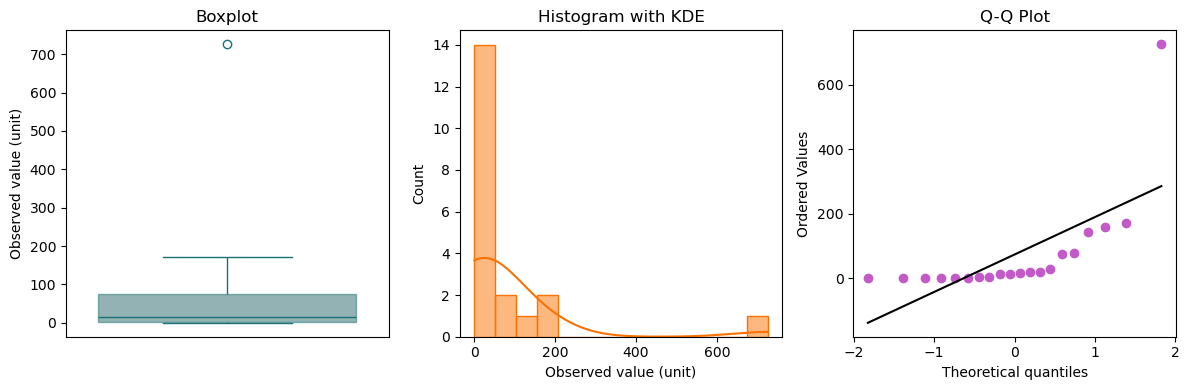

In [ ]:
# Visualizing the experimental data using boxplot, histogram, and Q-Q plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.boxplot(dataset_outliers.observed_value, linecolor='#1b7173', color='#1b7173',  boxprops=dict(alpha=.5), ax=axes[0])
axes[0].set_xticks([])
axes[0].set_ylabel('Observed value (unit)')
axes[0].set_title('Boxplot')

sns.histplot(dataset_outliers.observed_value, kde=True, color='#fc7202', edgecolor='#fc7202', ax=axes[1])
axes[1].set_xlabel('Observed value (unit)')
axes[1].set_ylabel('Count')
axes[1].set_title('Histogram with KDE')

stats.probplot(dataset_outliers.observed_value, dist="norm", plot=axes[2])
axes[2].get_lines()[0].set_markerfacecolor('#c25bc7')   # color of the points
axes[2].get_lines()[0].set_markeredgecolor('#c25bc7')
axes[2].get_lines()[1].set_color('black')             # color of the reference line
axes[2].set_title("Q-Q Plot")
plt.tight_layout()

> **Summary of the original dataset**
> | Metric | Value | Comment |
> |---|---:|---|
> | *n* | **20** | Sample size |
> | Mean | **74.12** | Much larger than median → suggests right skew |
> | Median | **15.90** | Central tendency less affected by extreme high value |
> | Std. deviation | **163.31** | Very large spread, inflated by extreme high value |
> | Q1 | **1.63** | 25th percentile |
> | Q3 | **76.10** | 75th percentile |
> | IQR (Q3 − Q1) | **74.48** | Middle 50% spread |
> | Tukey upper fence (Q3 + 1.5·IQR) | **187.82** | Values above this are flagged as outliers in a boxplot |
> | Min | **0.20** | Within expected range |
> | Max | **725.70** | **≫ 187.82** → extreme high value |
> | Skewness | **3.685** | Strong positive (right) skew |
> | Excess kurtosis | **14.814** | Very heavy right tail / outlier-prone |
>
> Visual diagnostics
> - Boxplot: a single, extreme point far above the upper whisker.  
> - Histogram: long right tail with one value near ~726.  
> - Q-Q plot: strong upward deviation in the upper tail (largest point off the line).
>
> Conclusion
> All indicators (extreme max, 1.5·IQR rule, heavy right skew, high excess kurtosis, and Q-Q plot tail behavior) are consistent with **one extreme high outlier** in the dataset (≈ **725.7**).
>
> *Next step:* We will apply the Grubbs’ test (*α* = 0.05) to formally determine whether the extreme value is a statistical outlier.\
> If the test confirms this, we will remove the outlier and recalculate the descriptive statistics and visualizations for the cleaned dataset.


> We can apply either a **one-tailed** or a **two-tailed** Grubbs’ test:
> - A **one-tailed test** is used when we specifically suspect that the outlier is on one side of the distribution\
> (for example, the **maximum** value (right tail) or the **minimum** value (left tail)).
> - A **two-tailed test** checks for outliers on **both ends** of the distribution simultaneously.
>
> In our case, the visualizations clearly show that the potential outlier is the **maximum value**.  
> However, we will perform the **two-tailed version** of the test, which will detect an outlier regardless of whether it lies on the high or low end.

In [170]:
# Apply the Grubbs' test (two-sided, α = 0.05)
# The grubbs.test() function automatically detects and removes any significant outlier(s), returning a new array with those outlier values excluded
data_without_outliers = pd.DataFrame(grubbs.test(dataset_outliers.observed_value, alpha=0.05))
data_without_outliers.head(10)

,observed_value
0,0.4
1,1.7
2,0.6
3,74.9
4,13.9
5,0.8
6,20.2
7,143.2
9,0.2
10,160.2


In [ ]:
data_without_outliers

,observed_value
count,19.000000
mean,39.821053
std,57.644404
min,0.200000
25%,1.550000
50%,14.700000
75%,51.250000
max,171.700000


Skewness of the cleaned dataset: 1.536
Excess kurtosis of the cleaned dataset: 0.991


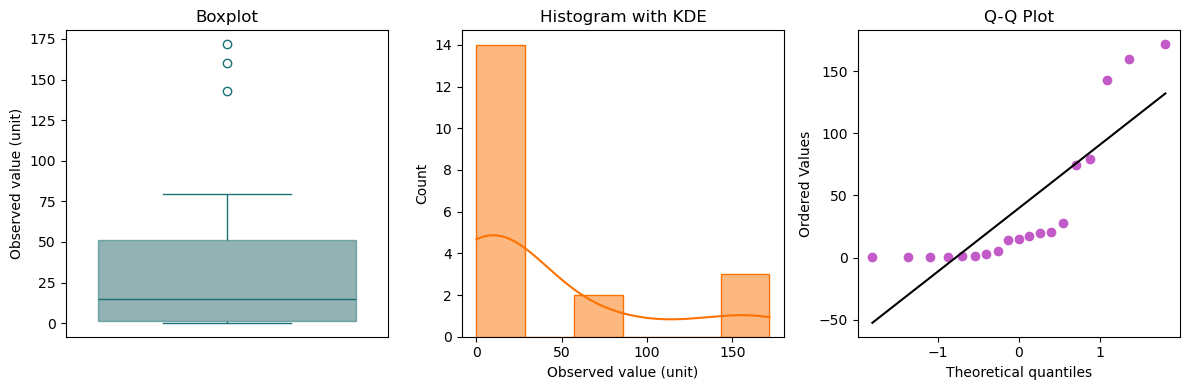

In [ ]:
# Display updated descriptive statistics for the cleaned dataset
display(data_without_outliers.describe())

# Calculating the skewness and excess kurtosis
print(f'Skewness of the cleaned dataset: {data_without_outliers.observed_value.skew():.3f}', flush=True)
print(f'Excess kurtosis of the cleaned dataset: {data_without_outliers.observed_value.kurt():.3f}', flush=True)

# Visualizing the cleaned data
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.boxplot(data_without_outliers.observed_value, linecolor='#1b7173', color='#1b7173',  boxprops=dict(alpha=.5), ax=axes[0])
axes[0].set_xticks([])
axes[0].set_ylabel('Observed value (unit)')
axes[0].set_title('Boxplot')

sns.histplot(data_without_outliers.observed_value, kde=True, color='#fc7202', edgecolor='#fc7202', ax=axes[1])
axes[1].set_xlabel('Observed value (unit)')
axes[1].set_ylabel('Count')
axes[1].set_title('Histogram with KDE')

stats.probplot(data_without_outliers.observed_value, dist="norm", plot=axes[2])
axes[2].get_lines()[0].set_markerfacecolor('#c25bc7')   # color of the points
axes[2].get_lines()[0].set_markeredgecolor('#c25bc7')
axes[2].get_lines()[1].set_color('black')             # color of the reference line
axes[2].set_title("Q-Q Plot")
plt.tight_layout()

> **After removing the clear outlier - what changed?**
> - ***n* = 19**, mean = **39.82**, median = **14.70**, sd = **57.64**  
> - Skewness = **1.536** (still strongly right-skewed)  
> - Excess kurtosis = **0.991** (heavier tail than normal)  
> - Max = **171.7**
>
> **Why isn’t it normal now?**  
> Because the **underlying distribution is genuinely skewed**, not just distorted by a single *"bad"* point.  
> The histogram and Q-Q plot still show a **long right tail** and **systematic curvature** (not just one extreme dot).  
> There are several **legitimate high values** that are *not* statistical outliers but collectively create skew.
>
> **Should we remove more points?**  
> **No.** Those observations are not outliers by formal criteria; trimming them would bias the analysis.  
> Instead, this is a case for a **transformation** or using **non-parametric methods**.
>
> *You could have already anticipated this from the **first visualizations**: a broad right tail, many moderate highs, and Q-Q curvature.* 
> *In the next task, we’ll handle such non-normal data appropriately.*


#### <font color="#fc7202">Task 2:</font>

A file named **`three_datasets.tsv`** contains (indeed) three different datasets.  
Exactly **one** of them is **already (approximately) normally distributed**.  
For the **other two**, your task is to find a **monotonic transformation** that makes them **approximately normal** - **without removing any data points** (no outlier trimming).

**Your goals:**
1) **Import** the data into Python.  
2) **Compute descriptive statistics** for each dataset (n, mean, median, sd, skewness, excess kurtosis, quartiles).  
3) **Visualize** each dataset (boxplot, histogram, Q-Q plot).  
4) **Identify** which dataset is already normal (use Q-Q plots + formal tests).  
5) For the **non-normal** datasets, **apply a suitable transformation**.  
6) **Re-evaluate normality** on the transformed data (Q-Q plots + Shapiro-Wilk).  
7) **Report your evidence**: show before/after plots and test *p*-values, and **justify** the chosen transformation (briefly).

In [ ]:
# YOUR CODE HERE!

In [171]:
three_datasets = pd.read_csv('three_datasets.tsv', sep='\t')

In [173]:
three_datasets.describe()

,n,dataset1,dataset2,dataset3
count,20.00000,20.000000,20.00000,20.000000
mean,10.50000,74.115000,71.62000,76.770000
std,5.91608,163.307947,43.56414,88.852593
min,1.00000,0.200000,1.00000,0.900000
25%,5.75000,1.625000,47.80000,14.375000
50%,10.50000,15.900000,68.65000,44.550000
75%,15.25000,76.100000,100.57500,113.075000
max,20.00000,725.700000,155.80000,333.600000


In [71]:
# Since we will repeatedly calculate and visualize the same statistics, let's define helper functions for cleaner and more compact code.

# Function for calculating summary statistics
def summary_stats(data):
    data = pd.Series(data).dropna()
    return pd.Series({'n': len(data), 'mean': data.mean(), 'median': data.median(), 'std': data.std(ddof=1),
                      'min': data.min(), 'q1': data.quantile(0.25), 'q3': data.quantile(0.75), 'max': data.max(),
                      'skewness': data.skew(), 'excess_kurtosis': data.kurt()}).round(3)


# Function for visualizing data (boxplot, histogram and Q-Q plot)
def visualize_distribution(data, color='#1b7173', dataset_name=''):
    data = pd.Series(data).dropna()
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Boxplot
    sns.boxplot(y=data, color=color, width=0.4, ax=axes[0])
    axes[0].set_title(f'Boxplot: {dataset_name}')
    axes[0].set_ylabel('Value')

    # Histogram + KDE
    sns.histplot(data, kde=True, color=color, edgecolor=color, alpha=0.6, ax=axes[1])
    axes[1].set_title(f'Histogram: {dataset_name}')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Density')

    # Q-Q Plot
    stats.probplot(data, dist='norm', plot=axes[2])
    axes[2].get_lines()[0].set_markerfacecolor('#c25bc7')
    axes[2].get_lines()[0].set_markeredgecolor('#c25bc7')
    axes[2].get_lines()[1].set_color('black')
    axes[2].set_title(f'Q-Q Plot: {dataset_name}')

    plt.tight_layout()
    plt.show()



dataset1 - Summary:


n                   20.000
mean                74.115
median              15.900
std                163.308
min                  0.200
q1                   1.625
q3                  76.100
max                725.700
skewness             3.685
excess_kurtosis     14.814
dtype: float64

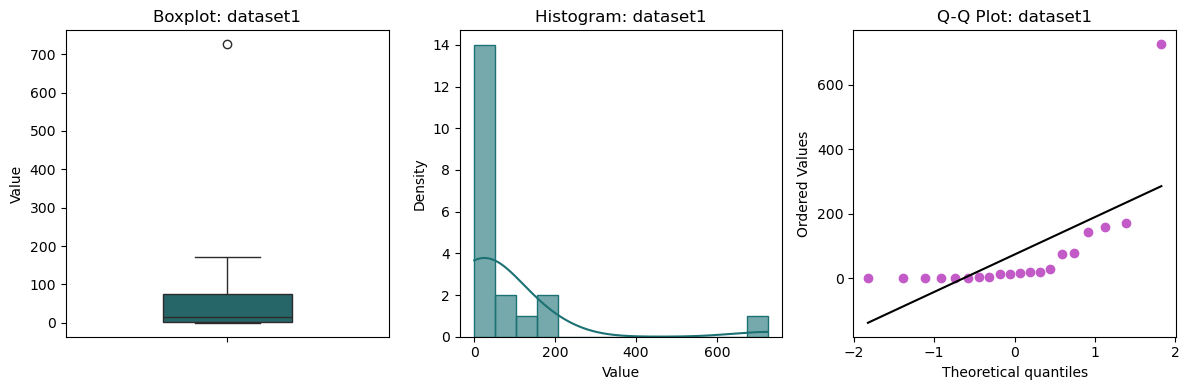


dataset2 - Summary:


n                   20.000
mean                71.620
median              68.650
std                 43.564
min                  1.000
q1                  47.800
q3                 100.575
max                155.800
skewness             0.349
excess_kurtosis     -0.365
dtype: float64

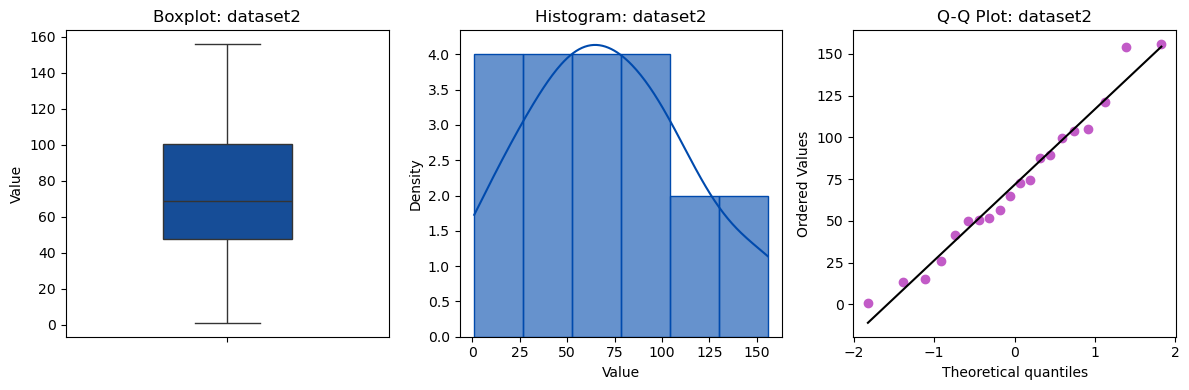


dataset3 - Summary:


n                   20.000
mean                76.770
median              44.550
std                 88.853
min                  0.900
q1                  14.375
q3                 113.075
max                333.600
skewness             1.823
excess_kurtosis      3.229
dtype: float64

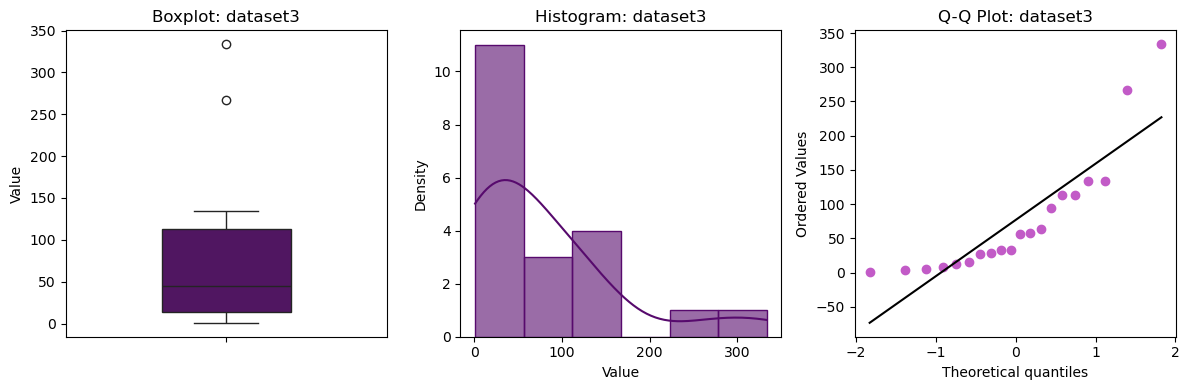

In [174]:
# And now we can use our functions
colors = ['#1b7173', '#004aad', '#570a6d']

for i, name in enumerate(three_datasets.columns[1:]):
    subset = three_datasets[name]
    print(f'\n{name} - Summary:')
    display(summary_stats(subset))
    visualize_distribution(subset, color=colors[i], dataset_name=name)


Based on the visulaizations (near-linear Q-Q plot, almost symmetric boxplot), **dataset2** appears closest to normal.  
Its descriptive statistics support this:
-  mean = **71.62**, median = **68.65** (mean ≈ median → little asymmetry)  
- **sd = 43.56**, **Q1 = 47.80**, **Q3 = 100.58**  
- **Skewness = 0.349** (within ±0.5 → approximately symmetric)  
- **Excess kurtosis = -0.365** (near 0 → tails/peak similar to normal)

**Conclusion:** Among the three, **dataset2** is the only one that looks **approximately normally distributed**.\
To confirm this observation statistically, let’s also perform the Shapiro–Wilk test for normality.

In [ ]:
# Checking the normality assumption using the Shapiro–Wilk test
# Null hypothesis (H0): the data come from a normal distribution
statistic_SW, p_value_SW = stats.shapiro(three_datasets.dataset2)
print(f'Shapiro-Wilk test statistic: {statistic_SW:.4f}, p-value: {p_value_SW:.4f}')

Shapiro-Wilk test statistic: 0.9674, p-value: 0.7002


> Since the *p*-value is much greater than 0.05, we **fail to reject the null hypothesis** that the data come from a normal distribution.  
> This confirms our visual assessment - **dataset2 can be considered normally distributed** at the 95 % confidence level.

The second part asks whether the **other two datasets** can be made **approximately normal** using a **monotonic transformation**, **without removing outliers**.

From the visuals and summary statistics, both non-normal datasets show **positive (right) skew**.\
Right-skewed data are often well-modeled by a **log-normal** process.\
We’ll try a **natural log transform** on the two non-normal datasets and then **recompute** the summaries, plots, and normality tests.

> **Note:** `log` requires strictly positive data.  
> If a dataset contains zeros or negatives, use a transformation that handles negative values and zeros naturally. For example, more flexible power transforms (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.power_transform.html).


In [79]:
three_datasets[['log_dataset1', 'log_dataset3']] = np.log(three_datasets[['dataset1', 'dataset3']])

three_datasets.head()

,n,dataset1,dataset2,dataset3,log_dataset1,log_dataset3
0,1,0.4,105.2,5.5,-0.916291,1.704748
1,2,1.7,15.2,57.2,0.530628,4.046554
2,3,0.6,103.8,26.7,-0.510826,3.284664
3,4,74.9,49.9,134.3,4.316154,4.900076
4,5,13.9,13.1,94.4,2.631889,4.547541



log_dataset1 - Summary:


n                  20.000
mean                2.412
median              2.763
std                 2.304
min                -1.609
q1                  0.482
q3                  4.332
max                 6.587
skewness           -0.092
excess_kurtosis    -0.922
dtype: float64

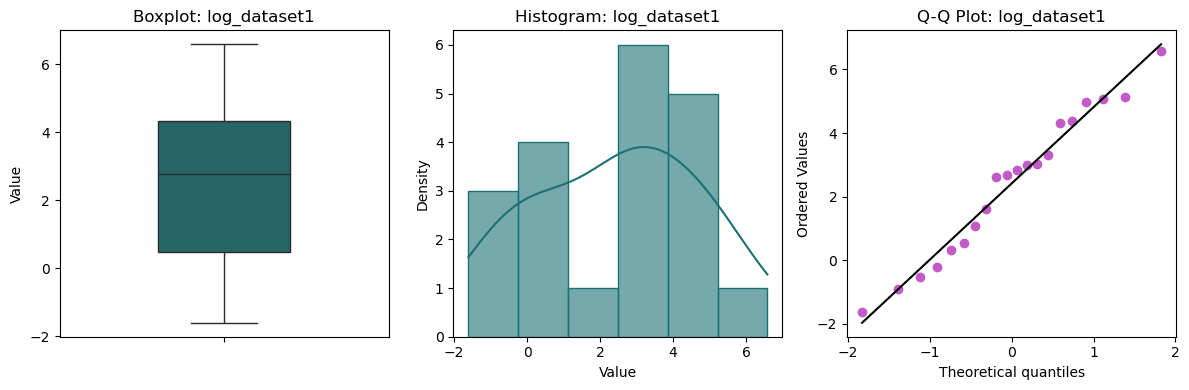


log_dataset3 - Summary:


n                  20.000
mean                3.577
median              3.764
std                 1.493
min                -0.105
q1                  2.662
q3                  4.728
max                 5.810
skewness           -0.740
excess_kurtosis     0.436
dtype: float64

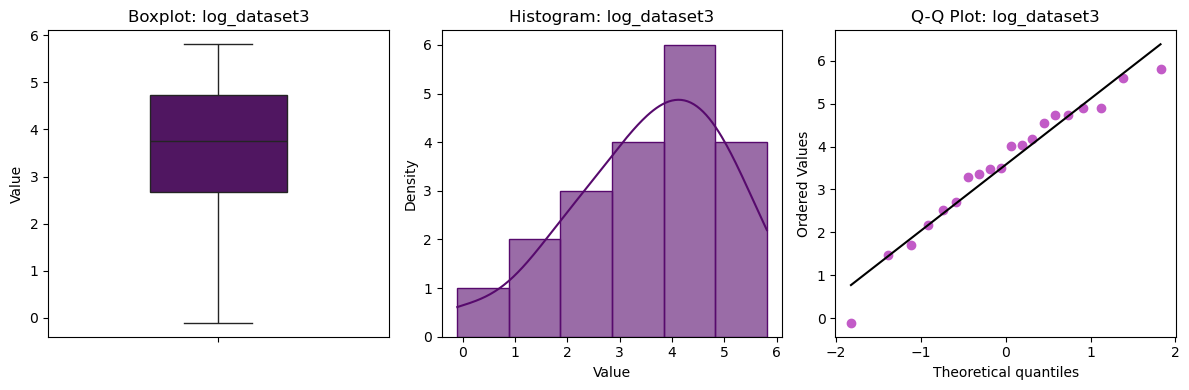

In [80]:
# Using our functions for summary statistics and visualizations
colors = ['#1b7173', '#570a6d']

for i, name in enumerate(three_datasets.columns[-2:]):
    subset = three_datasets[name]
    print(f'\n{name} - Summary:')
    display(summary_stats(subset))
    visualize_distribution(subset, color=colors[i], dataset_name=name)

**After log transformation: does normality hold?**

For **log_dataset1**  
- mean = 2.412, median = 2.763  (almost symmetric → slight negative skew)
- sd = 2.304, Q1 = 0.482, Q3 = 4.332  
- **skewness = -0.092** (≈ 0 → symmetric)  
- **excess kurtosis = -0.922** (slightly light-tailed)

For **log_dataset3**  
- mean = 3.577, median = 3.764  (almost symmetric → slight negative skew)
- sd = 1.493, Q1 = 2.662, Q3 = 4.728  
- **skewness = -0.740** (moderate left skew but much reduced)  
- **excess kurtosis = 0.436** (near 0)

**Visual assessment:** The Q-Q plots are close to a straight line with only mild tail deviation. 

To **confirm formally**, let’s run the **Shapiro-Wilk test** on both transformed datasets.

In [84]:
# Checking the normality assumption using the Shapiro–Wilk test
# Null hypothesis (H0): the data come from a normal distribution
statistic_SW_dataset1, p_value_SW_dataset1 = stats.shapiro(three_datasets.log_dataset1)
statistic_SW_dataset3, p_value_SW_dataset3 = stats.shapiro(three_datasets.log_dataset3)
print('Normality check after log-transformation:')
print(f'log_dataset1 → W = {statistic_SW_dataset1:.4f}, p = {p_value_SW_dataset1:.4f}')
print(f'log_dataset3 → W = {statistic_SW_dataset3:.4f}, p = {p_value_SW_dataset3:.4f}')

Normality check after log-transformation:
log_dataset1 → W = 0.9662, p = 0.6733
log_dataset3 → W = 0.9572, p = 0.4901


> Since both *p*-values exceed 0.05, there is no evidence of deviation from normality in the transformed datasets.
> We could proceed with **parametric methods** on the log scale for both datasets.

After successfully normalizing the skewed datasets using the log transformation, it’s worth reflecting on **why** we use such transformations and what trade-offs they involve.

#### Advantages and disadvantages of data transformation

**Advantages:**
- Helps data **meet the assumptions** of parametric tests (e.g., normality, equal variance).  
- **Preserves relative magnitudes** - the order and spacing between observations remain meaningful.  
- Can **reveal structure** in the data or provide insight into underlying processes/physical system.

**Disadvantages:**
- Results are expressed in **transformed units** (e.g., `log(µg/L)`), which can be **hard to interpret**.  
- **Alters the meaning** of hypothesis tests - for example, a *t*-test on log-transformed means tests for **ratios** rather than absolute differences ($\log(x_1) - \log(x_2) = \log(\frac{x_1}{x_2})$).  
- May complicate **communication of results**, since back-transformation is required for interpretation in the original scale.


## Part 2: Non-Parametric Tests

<div style="display: flex; align-items: flex-start; justify-content: space-between;">
  <div style="flex: 1; padding-right: 10px;">

Up to this point, we have used **parametric tests** such as the *t*-test and *F*-test, but we have not yet defined what actually makes a test *parametric*.

Parametric tests are based on specific **assumptions about the population**, most importantly that the data are **normally distributed** and that the **variances are similar** between groups.  
They also rely on **population parameters**, such as the **mean (μ)** and **standard deviation (σ)**, which is where the term *parametric* originates.

When these assumptions are met, parametric tests are generally **more powerful** because they make efficient use of all the data.  
However, if the data deviate strongly from normality, have unequal variances, or contain outliers, applying a parametric test can lead to **misleading conclusions**.

In such cases, it is better to use a **non-parametric test**.  
Non-parametric tests, sometimes called **distribution-free methods**, do not rely on strong assumptions about the data’s underlying distribution.  
They work on **ranks or medians** rather than means and are therefore **more robust** against skewed data and outliers, although typically **less sensitive** when the data are perfectly normal.

In practice, the goal is not to avoid non-parametric tests but to **choose the method that best fits the data**.  
If your dataset reasonably meets the assumptions, use a parametric test.  
If not, a non-parametric test provides a safer and more reliable alternative.

The diagram on the right summarizes this general decision process:  
when to stay within the parametric framework and when to switch to non-parametric approaches.

  </div>
  <div style="flex: 0 0 50%; text-align: right;">
    <img src="https://raw.githubusercontent.com/RaHub4AI/MI7032/refs/heads/main/Pictures/normal_nonnormal_data.png"
         alt="Workflow: choosing parametric vs. non-parametric tests"
         width="95%"
         style="border-radius: 8px;">
  </div>
</div>

In today’s session, we will focus on two widely used **non-parametric tests** that serve as direct alternatives to the *t*-tests we have used before:
- The **Wilcoxon Signed-Rank Test**, which is the non-parametric alternative to the **one-sample** *t*-test or the **paired two-sample** *t*-test.  
- The **Mann-Whitney U Test**, which replaces the **independent two-sample** *t*-test.  




#### The Wilcoxon Signed-Rank Test

The **Wilcoxon Signed-Rank Test** is used when we have **paired data** (two related samples) or when we want to test whether the **median** of a single sample differs from a hypothesized value.  

**How it works:**
1. For each observation, calculate the **difference** between the two paired values (or between the observed value and the hypothesized median).  
2. Ignore any pairs with a difference of 0.  
3. Take the **absolute values** of the differences and **rank** them from smallest to largest.  
4. Assign the **sign** of the original difference (+ or −) to each rank.  
5. Sum the ranks for positive ($W^+$) and negative ($W^-$) differences separately.  
6. The **test statistic** is often $W = \min(W^+, W^-)$ (i.e., the smaller of the two signed rank sums).
7. Under the null hypothesis (no median difference), the positive and negative ranks should be **balanced**.  
   For small samples, *critical values* of $W$ are tabulated.  
   For larger samples ($n > 10$), $W$ approximately follows a **normal distribution** with  $\mu_W = \frac{n(n+1)}{4}, \quad \sigma_W = \sqrt{\frac{n(n+1)(2n+1)}{24}}$\
   The standardized test statistic is then $Z = \frac{W - \mu_W}{\sigma_W}$ which can be compared to the standard normal distribution to obtain the *p*-value.

If the data come from a symmetric distribution centered around zero, positive and negative ranks balance out.  
A large imbalance between $W^+$ and $W^-$ indicates a systematic shift - evidence against $H_0$.

**Hypotheses:**

- $H_0$: The median difference between pairs is zero.  
- $H_1$: The median difference is not zero (two-tailed), or greater/less than zero (one-tailed).

---

**Example:**\
Let $X$ denote the length (in cm) of a randomly selected pygmy sunfish.\
Given the sample: $\{\,5.0,\; 3.9,\; 5.2,\; 5.5,\; 2.8,\; 6.1,\; 6.4,\; 2.6,\; 1.7,\; 4.3\,\}$ test whether the **population median** differs from **3.7 cm** at the 95% of confidence level.

*Hypotheses:*
- $H_0:\ \text{median}(X)=3.7$
- $H_1:\ \text{median}(X)\neq 3.7$

*Test choice:* Wilcoxon **signed-rank** test (one-sample, two-sided).  

<div style="display: flex; align-items: flex-start; justify-content: space-between;">
  <div style="flex: 1; padding-right: 10px;">

*Manual Calculation*

1. Compute the differences from the hypothesized median (3.7 cm)

| Observation | Value (cm) | Difference (x − 3.7) |
|:--:|--:|--:|
| 1 | 5.0 | +1.3 |
| 2 | 3.9 | +0.2 |
| 3 | 5.2 | +1.5 |
| 4 | 5.5 | +1.8 |
| 5 | 2.8 | −0.9 |
| 6 | 6.1 | +2.4 |
| 7 | 6.4 | +2.7 |
| 8 | 2.6 | −1.1 |
| 9 | 1.7 | −2.0 |
| 10 | 4.3 | +0.6 |

No zero differences, so $n = 10$.

2. Take absolute differences and rank them (smallest = 1)

| Observation | Difference | abs(Difference) | Rank | Signed Rank |
|:--:|--:|--:|--:|--:|
| 2 | +0.2 | 0.2 | 1 | +1 |
| 10 | +0.6 | 0.6 | 2 | +2 |
| 5 | −0.9 | 0.9 | 3 | −3 |
| 8 | −1.1 | 1.1 | 4 | −4 |
| 1 | +1.3 | 1.3 | 5 | +5 |
| 3 | +1.5 | 1.5 | 6 | +6 |
| 4 | +1.8 | 1.8 | 7 | +7 |
| 9 | −2.0 | 2.0 | 8 | −8 |
| 6 | +2.4 | 2.4 | 9 | +9 |
| 7 | +2.7 | 2.7 | 10 | +10 |

  </div>
  <div style="flex: 0 0 60%; text-align: left;">
    <img src="https://raw.githubusercontent.com/RaHub4AI/MI7032/refs/heads/main/Pictures/fish.png"
         alt="Workflow: choosing parametric vs. non-parametric tests"
         width="55%"
         style="border-radius: 8px;">
  </div>
</div>


3. Sum the positive and negative ranks
    - $W^+ = 1 + 2 + 5 + 6 + 7 + 9 + 10 = 40$
    - $W^- = 3 + 4 + 8 = 15$

4. Test statistic\
    $W = \min(W^+, W^-) = 15$

5. Decision\
For $n = 10$, two-sided critical region (α = 0.05) ≈ $W \leq 8$. (https://users.stat.ufl.edu/~winner/tables/wilcox_signrank.pdf)\
Since $W = 15 > 8$, we **fail to reject $H_0$**.

*Conclusion:* There is **no statistically significant evidence** that the median pygmy sunfish length differs from **3.7 cm**.  
Hence, the **median length ≈ 3.7 cm** is consistent with the sample data.




In [175]:
# Same test in Python using stats.wilcoxon()
x = np.array([5.0, 3.9, 5.2, 5.5, 2.8, 6.1, 6.4, 2.6, 1.7, 4.3])

# one-sample Wilcoxon signed-rank against median = 3.7
res = wilcoxon(x - 3.7, alternative='two-sided', zero_method='wilcox', method='exact')
print(f"W = {res.statistic:.0f}, p = {res.pvalue:.4f}")

W = 15, p = 0.2324


> *Conclusion (*α* = 0.05):* $p > 0.05$ → fail to reject $H_0$\
> There is no statistically significant evidence that the median pygmy sunfish length differs from 3.7 cm.

#### The Mann-Whitney *U* Test

The **Mann-Whitney *U* Test** (also known as the **Wilcoxon Rank-Sum Test**) compares **two independent samples** and tests whether one tends to have larger values than the other.  
It serves as the **non-parametric counterpart** to the *independent two-sample t-test*.

**How it works:**
1. Combine all observations from both groups into one dataset.  
2. Rank all values together from smallest to largest (assign average ranks for ties).  
3. Compute the **sum of ranks** for each group.  
4. The ***U* statistic** measures how much the ranks from one group differ from what would be expected under the null hypothesis of identical distributions.

If the distributions are truly the same, the ranks should be evenly mixed.  
If one group tends to have systematically higher or lower ranks, the test statistic will reflect this imbalance.

**Hypotheses:**
- $H_0$: The two groups come from the same population (distributions are identical).  
- $H_1$: The distributions differ (e.g., one tends to yield larger values).

---

**Example**

We have independent samples of **body mass (in grams)** from two lizard species:
- **Geckos:** 3.186, 2.427, 4.031, 1.995  
- **Anoles:** 5.515, 5.659, 6.739, 3.184  

We want to test whether the **two species differ in body mass**, without assuming normality and without specifying a direction of difference.

*Hypotheses:*
- $H_0$: The two species have the same population distribution (no difference in medians)
- $H_1$: The body mass distributions differ between Geckos and Anoles

Because the data are **not normally distributed** and the sample sizes are **small (*n* = 4 per group)**,  
we use the **Mann-Whitney U test**, a **non-parametric alternative** to the independent two-sample *t*-test.

*Manual calculation*

<div style="display: flex; align-items: flex-start; justify-content: space-between;">
  <div style="flex: 1; padding-right: 10px;">

1. Pool all observations and rank from smallest to largest (no ties here):

| Value | Group | Rank |
|:-----:|:----:|:---:|
| 1.995 | G | 1 |
| 2.427 | G | 2 |
| 3.184 | A | 3 |
| 3.186 | G | 4 |
| 4.031 | G | 5 |
| 5.515 | A | 6 |
| 5.659 | A | 7 |
| 6.739 | A | 8 |

2. Sum of ranks  
- Geckos: $R_G = 1 + 2 + 4 + 5 = 12$  
- Anoles: $R_A = 3 + 6 + 7 + 8 = 24$

3. U statistics \
$(n_G = n_A = 4)$\
$U_G = R_G - \frac{n_G(n_G+1)}{2} = 12 - 10 = 2$\
$U_A = R_A - \frac{n_A(n_A+1)}{2} = 24 - 10 = 14$

    The test statistic is: $U = \min(U_G, U_A) = \mathbf{2}$

  </div>
  <div style="flex: 0 0 60%; text-align: left;">
    <img src="https://raw.githubusercontent.com/RaHub4AI/MI7032/refs/heads/main/Pictures/geckos_anoles.png"
         alt="Workflow: choosing parametric vs. non-parametric tests"
         width="55%"
         style="border-radius: 8px;">
  </div>
</div>

4. Decision (two-sided, α = 0.05):  
For $n_1=n_2=4$, the **critical value** is $U_{crit} = 0$ (https://media.geeksforgeeks.org/wp-content/uploads/20201110022047/mannwhitneytwotailed.PNG)\
Since our observed value $U=2$ is greater than the critical value, we fail to reject the null hypothesis.\
There is no statistically significant difference between the two groups at the 5% significance level.



In [176]:
geckos = np.array([3.186, 2.427, 4.031, 1.995])
anoles = np.array([5.515, 5.659, 6.739, 3.184])

# Two-sided, exact method for small samples
res = mannwhitneyu(geckos, anoles, alternative='two-sided', method='exact')
print(f"U = {res.statistic}, p-value = {res.pvalue:.4f}")

U = 2.0, p-value = 0.1143


> *Conclusion:* Since this *p*-value is greater than the significance level (*α* = 0.05), we fail to reject the null hypothesis.
There is no statistically significant difference in the median body mass between geckos and anoles.

#### <font color="#fc7202">Task 3:</font>

The lead concentration in the blood (pg/mL) of seven children from Stockholm was measured as follows:
> 104, 79, 98, 150, 87, 136, 101

We want to know whether these data differ significantly from the Swedish population median, which is reported to be 95 pg/mL.

Your tasks:
1. Formulate the hypotheses clearly.
2. Apply both a Wilcoxon signed-rank test and a one-sample *t*-test to evaluate whether the Stockholm sample differs significantly from the population median (or mean).
3. Compare and interpret the results of both tests.


In [ ]:
# YOUR CODE HERE!

In [114]:
pb_children = pd.DataFrame({'child': np.arange(1, 8),
                            'pb_conc_pg_mL': [104, 79, 98, 150, 87, 136, 101]})

In [120]:
pb_children.describe()

,child,pb_conc_pg_mL
count,7.000000,7.000000
mean,4.000000,107.857143
std,2.160247,25.803285
min,1.000000,79.000000
25%,2.500000,92.500000
50%,4.000000,101.000000
75%,5.500000,120.000000
max,7.000000,150.000000


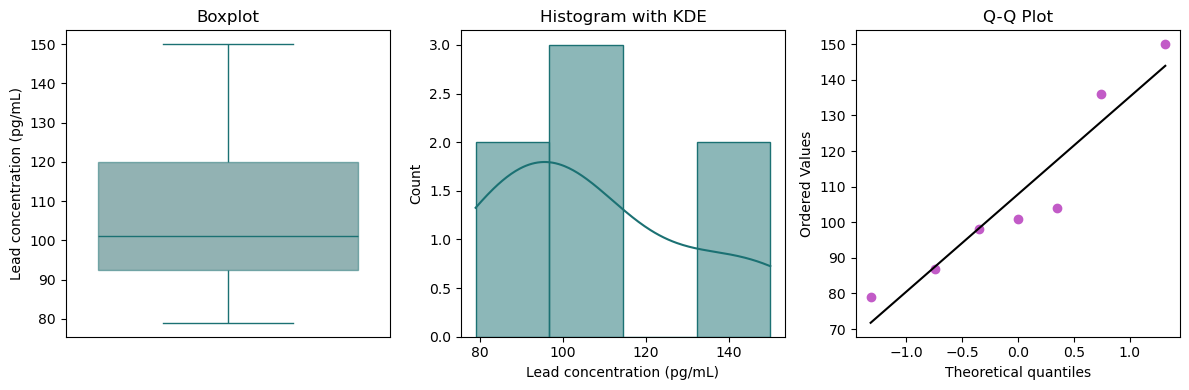

In [119]:
# Visualizing the experimental data using boxplot, histogram, and Q-Q plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.boxplot(pb_children.pb_conc_pg_mL, linecolor='#1b7173', color='#1b7173',  boxprops=dict(alpha=.5), ax=axes[0])
axes[0].set_xticks([])
axes[0].set_ylabel('Lead concentration (pg/mL)')
axes[0].set_title('Boxplot')

sns.histplot(pb_children.pb_conc_pg_mL, kde=True, color='#1b7173', edgecolor='#1b7173', ax=axes[1])
axes[1].set_xlabel('Lead concentration (pg/mL)')
axes[1].set_ylabel('Count')
axes[1].set_title('Histogram with KDE')

stats.probplot(pb_children.pb_conc_pg_mL, dist="norm", plot=axes[2])
axes[2].get_lines()[0].set_markerfacecolor('#c25bc7')   # color of the points
axes[2].get_lines()[0].set_markeredgecolor('#c25bc7')
axes[2].get_lines()[1].set_color('black')             # color of the reference line
axes[2].set_title("Q-Q Plot")
plt.tight_layout()

In [ ]:
# Checking the normality assumption using the Shapiro–Wilk test
# Null hypothesis (H0): the data come from a normal distribution
statistic_SW_Pb, p_value_SW_Pb = shapiro(pb_children.pb_conc_pg_mL)
print(f'Shapiro-Wilk test statistic: {statistic_SW_Pb:.4f}, p-value: {p_value_SW_Pb:.4f}')

Shapiro-Wilk test statistic:  0.8992, p-value: 0.3263


> Since *p*-value > 0.05, we fail to reject the null hypothesis - the data are consistent with normality. 
> We can proceed with parametric methods.

**One-sample *t*-test (one-sample, two-sided)**\
This test evaluates the **mean** (not the median).\
*Hypotheses*
- $H_0:\ \mu = 95$
- $H_1:\ \mu \neq 95$

In [123]:
t_stat_Pb, p_val_Pb = ttest_1samp(pb_children.pb_conc_pg_mL, popmean=95 ,alternative='two-sided')
print(f't-statistic: {t_stat_Pb:.4f}, p-value: {p_val_Pb:.4f}')

t-statistic: 1.3183, p-value: 0.2355


> Since *p*-value > 0.05, we fail to reject $H_0$ - the mean Pb concentration is not significantly different from 95 pg/mL.

*Next:* let’s run the non-parametric counterpart (Wilcoxon signed-rank test) to test the median = 95 pg/mL:

**Wilcoxon signed-rank test (one-sample, two-sided)**\
*Hypotheses:*
- $H_0:\ \text{median} = 95 $ 
- $H_1:\ \text{median} \neq 95$


In [128]:
w_statistic_Pb, w_p_value_Pb = wilcoxon(pb_children.pb_conc_pg_mL - 95, zero_method='wilcox', alternative='two-sided', method='exact')
print(f"Wilcoxon: W = {w_statistic_Pb:.0f}, p = {w_p_value_Pb:.3f}")

Wilcoxon: W = 8, p = 0.375


> With *p* > 0.05, we fail to reject $H_0$, indicating no significant difference between the Pb concentration in Stockholm children and the reference value of 95 pg/mL.\
> This agrees with the one-sample *t*-test result.

Although both the *t*-test and the Wilcoxon signed-rank test led to the same conclusion, we see that the *p*-value from the non-parametric test is higher than that of the *t*-test.
This difference reflects the lower statistical power of non-parametric methods **when the normality assumption is reasonably met**. Parametric tests, such as the *t*-test, make stronger assumptions about the data distribution and are therefore more powerful - they are more likely to detect a true difference if one exists.

> In this case, since the data appear approximately normal, the *t*-test provides a slightly stronger result (lower *p*-value), but both tests consistently indicate no significant difference from the reference value.


#### Statistical Power and Sample Size

The power of a statistical test is the probability of correctly rejecting the null hypothesis when it is false. In other words, the probability of detecting a true effect.\
High power means that the test is sensitive enough to identify real differences when they exist.

Statistical power depends on four key factors:
- Effect size: how large the true difference or relationship is
- Sample size: the number of observations available
- Significance level (*α*): how strict our threshold for Type I error is (commonly 0.05)
- Data variability: how much random noise or spread there is in the data

A common rule of thumb is to aim for a power of **0.8 (80%)**, meaning there is an 80% chance of detecting an effect of the specified size if it truly exists.

**Why power matters?**\
The main use of statistical power is in power analysis, which is typically performed before an experiment to ensure that the study design is adequate. Power analysis helps determine the minimum sample size needed to detect an effect of a given size with reasonable certainty, for example, “How many measurements are needed to reliably detect a change?”

If the available sample size is fixed, power analysis can also be used to estimate the smallest effect size that can be detected with acceptable confidence.

Power is crucial because both extremes, too little or too much power, can lead to problems:
- An underpowered study is likely to be inconclusive, failing to detect real effects and contributing to issues like the replication crisis in science.
- An overpowered study, on the other hand, can be wasteful, detecting even trivial effects that have no real practical meaning and consuming unnecessary resources (e.g., testing more samples or animal subjects than ethically needed).

For this reason, funding agencies, ethics boards, and research review panels often require a power analysis as part of experimental design and justification.

**Choosing an effect size**\
The effect size represents the magnitude of the difference or association we want to be able to detect.
It can be based on:
- Previous studies or literature values
- Scientific or practical relevance (e.g., a difference large enough to matter in practice)
- Pilot data or preliminary measurements

In the context of a *t*-test, the effect size is often expressed as **Cohen’s *d***, which quantifies the difference between means relative to the variability in the data: $d = \frac{|\bar{x}_1 - \bar{x}_2|}{s_p}$, where  
- $\bar{x}_1$ and $\bar{x}_2$ are group means 
- $s_p$ is pooled standard deviation  

> Because measurements can be made in different **units or scales**, raw mean differences are not directly comparable.  
> Cohen’s *d* standardizes the difference between means in **units of standard deviation**, making the results easier to interpret and compare across studies.

Typical interpretation (Cohen, 1988):  
- **Small effect:** $d \approx 0.2$  
- **Medium effect:** $d \approx 0.5$  
- **Large effect:** $d \approx 0.8$ or greater

Larger effect sizes are easier to detect (higher power), while smaller effect sizes require larger sample sizes to achieve the same power.

**Calculating test power**\
In Python, we can estimate the power of a *t*-test using functions from `statsmodels.stats.power`.\
For example, if we want to check the power for detecting a given difference from 95 pg/mL (Task 3):

In [177]:
from statsmodels.stats.power import TTestPower

# Parameters
mean_sample = np.mean(pb_children.pb_conc_pg_mL)
std_sample = np.std(pb_children.pb_conc_pg_mL, ddof=1)
mu_ref = 95
alpha = 0.05
n = len(pb_children)  # use actual sample size

# Compute Cohen's d (effect size)
effect_size = (mean_sample - mu_ref) / std_sample

# Power analysis
power_analysis = TTestPower()
power = power_analysis.power(effect_size=effect_size, nobs=n, alpha=alpha, alternative='two-sided')

print(f'Cohen\'s d (effect size): {effect_size:.3f}')
print(f'Sample size: {n}, α = {alpha}')
print(f'Estimated statistical power: {power:.3f}')


Cohen's d (effect size): 0.498
Sample size: 7, α = 0.05
Estimated statistical power: 0.200


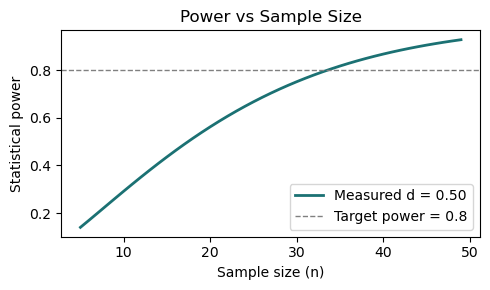

In [178]:
# Let's visualize how the statistical power changes with sample size
sample_sizes = np.arange(5, 50)
power_values = [power_analysis.power(effect_size=effect_size, nobs=n, alpha=0.05, alternative='two-sided') for n in sample_sizes]

plt.figure(figsize=(5, 3))
plt.plot(sample_sizes, power_values, label=f'Measured d = {effect_size:.2f}', lw=2, color='#1b7173')
plt.axhline(0.8, color='gray', ls='--', lw=1, label='Target power = 0.8')

plt.xlabel('Sample size (n)')
plt.ylabel('Statistical power')
plt.title('Power vs Sample Size')
plt.legend()
plt.tight_layout()
plt.show()

> We can also reverse the calculation: given a desired power (e.g. 0.8) and effect size, find the required sample size:

In [179]:
# Calculate the required sample size to achieve 80% statistical power given the observed effect size, significance level (alpha), and two-sided test
required_n = power_analysis.solve_power(effect_size=effect_size, power=0.8, alpha=alpha, alternative='two-sided')
print(f'Required sample size for 80% power: {required_n:.1f}')

Required sample size for 80% power: 33.6
